In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
%load_ext autoreload
%autoreload 2
print('TF version:', tf.__version__ , '\nGPU available:', tf.test.is_gpu_available())

TF version: 2.0.0 
GPU available: True


# MovieLens Dataset

In [2]:
path = '../'
data_path = 'datasets/' # Paperspace
file_name = 'am_like_ml_01'

In [3]:
df = pd.read_pickle(path + data_path + file_name)
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes
df.head()

,user_id,user,item,datetime,rating,item_id
0,0,A0039616ADOZ0KMWQRNX,B00QFJG1U8,2016-10-04,5.0,87754
1,0,A0039616ADOZ0KMWQRNX,B010ACF2PK,2016-10-04,5.0,104761
2,0,A0039616ADOZ0KMWQRNX,B00BFE0IZ2,2016-10-04,5.0,42989
3,0,A0039616ADOZ0KMWQRNX,B01CZMQCPC,2016-10-04,5.0,127248
4,0,A0039616ADOZ0KMWQRNX,B01B5DLG7G,2016-10-26,4.0,123866


# Init Params

In [4]:
res_ext = file_name[:2]
total_items = len(df.item_id.unique())
first_model_id = str(0) + '_' + res_ext

In [5]:
all_models = pd.read_pickle(path + 'results/' + res_ext + '/all_models')
# new_model_id = str(int(all_models.model_id.max()[0]) + 1) + '_' + res_ext

In [6]:
all_models

,model_id,train_time,epochs,BATCH_SIZE,learning_rate,delta,max_seq_len,embedding_dim,rnn_units,val_perc,test_perc,n_items_val,n_items_test,pad_value,shift_targets_by,loss,recall,val_loss,val_recall,test_recall
0,0_am,18013.840090,200,16,0.1,0.2,18,100,20,0.1,0.1,0,1,135784,1,"[2.554909733422284, 2.533241045152025, 2.46037...","[2.9381583e-06, 0.00013195378, 0.0002920571, 0...","[4.938571519190722, 4.908481937823909, 4.74607...","[7.3646435e-05, 0.00019554954, 0.00045513033, ...",0.006154
1,1_am,13535.720657,160,16,0.3,0.2,18,100,20,0.1,0.1,0,1,135784,1,"[2.492791804774054, 2.2577781175157705, 2.2073...","[0.000210802, 0.0020089652, 0.005307905, 0.009...","[4.710240729964606, 4.646537842136799, 4.62718...","[0.0008115798, 0.0032872779, 0.007526714, 0.01...",0.006154
2,5_am,20846.932909,200,32,0.1,0.2,30,100,50,0.1,0.1,0,1,135784,1,"[1.8265074285967597, 1.820659847388714, 1.8136...","[0.0, 0.0, 5.561642e-05, 0.00017923162, 0.0003...","[3.542339720726013, 3.5360026788711547, 3.5261...","[0.0, 0.0, 0.00011016104, 0.00022123894, 0.000...",0.003077
3,6_am,22982.548593,200,32,0.3,0.2,30,100,50,0.1,0.1,0,1,135784,1,"[1.8206264367831753, 1.7478289891933572, 1.602...","[1.6873295e-05, 0.0003124849, 0.0017495692, 0....","[3.5291484594345093, 3.3599658823013305, 3.323...","[9.494675e-05, 0.00086618867, 0.0027825893, 0....",0.005538
4,7_am,28558.309178,200,16,0.1,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.48747242005367586, 0.4793317374576048, 0.46...","[0.0, 5.3082982e-05, 0.00014864586, 0.00021017...","[3.3119295375181896, 3.302900663696893, 3.2845...","[0.0, 0.00010310501, 0.00016938652, 0.00022666...",0.006154
5,8_am,30543.622423,161,16,0.3,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.47687314659026747, 0.3434375589208797, 0.27...","[7.4939e-05, 0.00035860614, 0.0007600899, 0.00...","[3.27543308239172, 3.2868811257995003, 3.33043...","[0.0001913656, 0.00055657554, 0.0010071265, 0....",0.009231
6,9_am,28914.833008,172,16,0.1,0.6,30,100,20,0.1,0.1,0,1,135784,1,"[0.36525425487863167, 0.36047429656105234, 0.3...","[0.0, 1.0721208e-05, 0.000107472086, 0.0001692...","[2.378137436243567, 2.3730297124031745, 2.3672...","[0.0, 8.837572e-05, 0.00016628666, 0.000169386...",0.003077
7,10_am,32447.180922,172,16,0.3,0.6,30,100,20,0.1,0.1,0,1,135784,1,"[0.35959263617549037, 0.2782717178589458, 0.20...","[5.1701416e-05, 0.00027426844, 0.0005778312, 0...","[2.360568891657461, 2.3202049153866153, 2.3722...","[0.00016938652, 0.000488495, 0.00066382345, 0....",0.006154
8,2_am,37728.076944,200,32,0.1,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.48949657668694485, 0.48542612732337614, 0.4...","[0.0, 0.0, 1.3075499e-05, 9.339205e-05, 0.0001...","[3.317415142059326, 3.3130080938339233, 3.3085...","[0.0, 0.0, 8.7734064e-05, 0.00010310488, 0.000...",0.006154
9,3_am,36173.264363,200,32,0.3,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.4853863109251842, 0.46703839228658256, 0.37...","[5.960496e-06, 0.00014358677, 0.00027341425, 0...","[3.3082576990127563, 3.272194962501526, 3.2140...","[8.837564e-05, 0.00020663152, 0.00039936486, 0...",0.012308


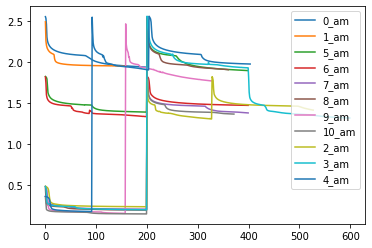

In [7]:
for value in all_models['loss']:
    plt.plot(value)
    plt.legend(all_models['model_id'])
plt.show()

In [8]:
params = {
'model_id':first_model_id,
'train_time':0,
'epochs':0,

# Grid Search params
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.2,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
    
'val_perc':0.1,          # Percentage of users from df in val and test set
'test_perc':0.1, 
'n_items_val':0,        # Number of last (chronologically) items in val and test set
'n_items_test':1,

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1  
}

In [9]:
BATCH_SIZE = params['BATCH_SIZE']
learning_rate = params['learning_rate']
delta = params['delta']
max_seq_len = params['max_seq_len']

val_perc = params['val_perc']
test_perc = params['test_perc']
n_items_val = params['n_items_val']
n_items_test = params['n_items_test']

pad_value = params['pad_value']
shift_targets_by = params['shift_targets_by'] 

embedding_dim = params['embedding_dim']
rnn_units = params['rnn_units']

# Imports

In [18]:
from Data_prep import train_val_test_split, create_seq_batch_dataset
from Models import build_LSTM_model, store_LSTM_model
from Evaluation import recall_metric, diversity_bias_loss, create_diversity_bias, get_predictions, get_metrics
from Helpers import TimingCallback
import time

# Init Datasets

In [11]:
# Train Test Val Split
data_split = train_val_test_split(df, val_perc, test_perc, n_items_val, n_items_test, seqs=True)
train_set, val_set, val_left_out_items, test_set, test_left_out_items = data_split 

# Configure Checkpoint directory

In [12]:
ext = '_' + file_name[:2] #ML or Am
# directory = './ckpts/ckpts' 
directory = '../ckpts/ckpts'

---
# Grid Search

In [13]:
all_models

,model_id,train_time,epochs,BATCH_SIZE,learning_rate,delta,max_seq_len,embedding_dim,rnn_units,val_perc,test_perc,n_items_val,n_items_test,pad_value,shift_targets_by,loss,recall,val_loss,val_recall,test_recall
0,0_am,18013.840090,200,16,0.1,0.2,18,100,20,0.1,0.1,0,1,135784,1,"[2.554909733422284, 2.533241045152025, 2.46037...","[2.9381583e-06, 0.00013195378, 0.0002920571, 0...","[4.938571519190722, 4.908481937823909, 4.74607...","[7.3646435e-05, 0.00019554954, 0.00045513033, ...",0.006154
1,1_am,13535.720657,160,16,0.3,0.2,18,100,20,0.1,0.1,0,1,135784,1,"[2.492791804774054, 2.2577781175157705, 2.2073...","[0.000210802, 0.0020089652, 0.005307905, 0.009...","[4.710240729964606, 4.646537842136799, 4.62718...","[0.0008115798, 0.0032872779, 0.007526714, 0.01...",0.006154
2,5_am,20846.932909,200,32,0.1,0.2,30,100,50,0.1,0.1,0,1,135784,1,"[1.8265074285967597, 1.820659847388714, 1.8136...","[0.0, 0.0, 5.561642e-05, 0.00017923162, 0.0003...","[3.542339720726013, 3.5360026788711547, 3.5261...","[0.0, 0.0, 0.00011016104, 0.00022123894, 0.000...",0.003077
3,6_am,22982.548593,200,32,0.3,0.2,30,100,50,0.1,0.1,0,1,135784,1,"[1.8206264367831753, 1.7478289891933572, 1.602...","[1.6873295e-05, 0.0003124849, 0.0017495692, 0....","[3.5291484594345093, 3.3599658823013305, 3.323...","[9.494675e-05, 0.00086618867, 0.0027825893, 0....",0.005538
4,7_am,28558.309178,200,16,0.1,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.48747242005367586, 0.4793317374576048, 0.46...","[0.0, 5.3082982e-05, 0.00014864586, 0.00021017...","[3.3119295375181896, 3.302900663696893, 3.2845...","[0.0, 0.00010310501, 0.00016938652, 0.00022666...",0.006154
5,8_am,30543.622423,161,16,0.3,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.47687314659026747, 0.3434375589208797, 0.27...","[7.4939e-05, 0.00035860614, 0.0007600899, 0.00...","[3.27543308239172, 3.2868811257995003, 3.33043...","[0.0001913656, 0.00055657554, 0.0010071265, 0....",0.009231
6,9_am,28914.833008,172,16,0.1,0.6,30,100,20,0.1,0.1,0,1,135784,1,"[0.36525425487863167, 0.36047429656105234, 0.3...","[0.0, 1.0721208e-05, 0.000107472086, 0.0001692...","[2.378137436243567, 2.3730297124031745, 2.3672...","[0.0, 8.837572e-05, 0.00016628666, 0.000169386...",0.003077
7,10_am,32447.180922,172,16,0.3,0.6,30,100,20,0.1,0.1,0,1,135784,1,"[0.35959263617549037, 0.2782717178589458, 0.20...","[5.1701416e-05, 0.00027426844, 0.0005778312, 0...","[2.360568891657461, 2.3202049153866153, 2.3722...","[0.00016938652, 0.000488495, 0.00066382345, 0....",0.006154
8,2_am,37728.076944,200,32,0.1,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.48949657668694485, 0.48542612732337614, 0.4...","[0.0, 0.0, 1.3075499e-05, 9.339205e-05, 0.0001...","[3.317415142059326, 3.3130080938339233, 3.3085...","[0.0, 0.0, 8.7734064e-05, 0.00010310488, 0.000...",0.006154
9,3_am,36173.264363,200,32,0.3,0.6,18,100,20,0.1,0.1,0,1,135784,1,"[0.4853863109251842, 0.46703839228658256, 0.37...","[5.960496e-06, 0.00014358677, 0.00027341425, 0...","[3.3082576990127563, 3.272194962501526, 3.2140...","[8.837564e-05, 0.00020663152, 0.00039936486, 0...",0.012308


In [21]:
learning_rates = [0.1, 0.3]
epochs = [1]
deltas = [0.2, 0.6]
batch_sizes = [16, 32]
max_seq_lens = [18, 30] #Median=18
rnn_units = [20, 50]
rank_at = 20

total_runs = len(learning_rates) * len(epochs) * len(deltas) * len(batch_sizes) * len(max_seq_lens) * len(rnn_units)
runs = 0
print(f'Total runs: {total_runs}')

Total runs: 32


In [22]:
metrics=[recall_metric(total_items=total_items)]
for epoch in epochs:
    params['epochs'] = epoch
    for delta in deltas:
        params['delta'] = delta
        
        # Pre-Calculate diversity_bias
        diversity_bias = create_diversity_bias(train_set, total_items, delta)
        loss=diversity_bias_loss(db=diversity_bias, total_items=total_items)
        
        for rnn_unit in rnn_units:
            params['rnn_units'] = rnn_unit
        
            for batch_size in batch_sizes:
                params['BATCH_SIZE'] = batch_size
                
                # Rebuild model 
                model = build_LSTM_model(total_items = total_items, embedding_dim = embedding_dim, mask_value = pad_value, rnn_units = rnn_unit, batch_size = batch_size, return_sequences=True)

                for max_seq_len in max_seq_lens:
                    params['max_seq_len'] = max_seq_len

                    # Create new datasets
                    train_dataset = create_seq_batch_dataset(df=train_set, shift=shift_targets_by, max_seq_len=max_seq_len, pad_value=pad_value, batch_size=batch_size, stats=False, drop_remainder=True)
                    val_dataset = create_seq_batch_dataset(df=val_set, shift=shift_targets_by, max_seq_len=max_seq_len, pad_value=pad_value, batch_size=batch_size, stats=False, drop_remainder=True) 

                    for learning_rate in learning_rates:
                        runs += 1
                        s = time.time()

                        # Print current run
                        print('='*50, '\nRun:', str(runs) + '/' + str(total_runs))
                        print('Number of epochs:\t', epoch)
                        print('Number of (h) units:\t', rnn_unit)
                        print('Batch size:\t\t', batch_size)
                        print('Max seq len:\t\t', max_seq_len)
                        print('Learning rate:\t\t', learning_rate)

                        params['learning_rate'] =  learning_rate

                        # Compile Model
                        model = build_LSTM_model(total_items = total_items, embedding_dim = embedding_dim, mask_value = pad_value, rnn_units = rnn_unit, batch_size = batch_size, return_sequences=True)
                        optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate)

                        model.compile(optimizer=optimizer,
                                      loss=loss, 
                                      metrics=metrics)

                        # Create Callbacks
                        checkpoint_dir = directory + '_' + str(params['model_id'])
                        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
                        
                        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix, monitor = 'val_recall', mode = 'max', save_best_only = True, save_weights_only = True)
                        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_recall', min_delta = 0.0001, mode = 'max', patience = 15)
                        timing_callback = TimingCallback()
                        callbacks = [checkpoint_callback, early_stopping_callback, timing_callback]
                        
                        # Run 
                        history = model.fit(x=train_dataset, 
                                            validation_data=val_dataset, 
                                            epochs=epoch,
                                            callbacks=callbacks,
                                            verbose=1)
                        
                        
                        # Restore lates checkpoint and predict 
                        model = build_LSTM_model(total_items = total_items, embedding_dim = embedding_dim, mask_value = pad_value, rnn_units = rnn_unit, batch_size = None, return_sequences=False)
                        model.load_weights(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()
                        model.build(tf.TensorShape([1, None]))
                        test_batch_size = 1
                        preds_df = get_predictions(model, test_set, test_left_out_items, test_batch_size, max_seq_len, pad_value, rank_at)
                        metrics_test = get_metrics(preds_df, 5, rank_at)
#                         print(metrics_test)
                        
                        # Store model
                        store_path = path + 'results/' + res_ext + '/all_models_2'
                        train_time = np.sum(timing_callback.logs)
                        all_models = store_LSTM_model(store_path, params.copy(), history.history.copy(), train_time, metrics_test, store=True)
                        
                        # Change Model Id for next model
                        params['model_id'] = str(int(params['model_id'][0]) + 1) + '_am'
                        print(f'Run Time: {time.time() - s}')


Run: 1/32
Number of epochs:	 1
Number of (h) units:	 20
Batch size:		 16
Max seq len:		 18
Learning rate:		 0.1
812/812 [==============================] - 83s 103ms/step - loss: 2.5549 - recall: 3.0499e-06 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Obtaining metrics time: 1.33
Run Time: 147.01945400238037
Run: 2/32
Number of epochs:	 1
Number of (h) units:	 20
Batch size:		 16
Max seq len:		 18
Learning rate:		 0.3
    195/Unknown - 22s 114ms/step - loss: 2.5700 - recall: 0.0000e+00WARNING:tensorflow:Can save best model only with val_recall available, skipping.
    195/Unknown - 22s 114ms/step - loss: 2.5700 - recall: 0.0000e+00

KeyboardInterrupt: 